In [1]:
pip install open-tamil scikit-learn pandas numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for open-tamil: filename=Open_Tamil-1.1-py3-none-any.whl size=2388368 sha256=1f1e756d916cfceb2cafddbe816fa13b4bb951c4293df719bc50da78c9196a19
  Stored in directory: /root/.cache/pip/wheels/d3/48/47/d7829e657a9d52e32a566bc6d8a4be9235d0c52d2539f10ead
Successfully built open-tamil
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install indic-nlp-library open-tamil scikit-learn pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import re
import requests
from tamil.utf8 import get_words  # Tamil tokenizer from open-tamil
from indicnlp.tokenize import indic_tokenize  # Tamil tokenization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score


In [4]:
# Download Tamil stopwords list from GitHub
url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ta/master/stopwords-ta.txt"
response = requests.get(url)
tamil_stopwords = set(response.text.split("\n"))  # Convert to a set


In [5]:
# Load dataset
df = pd.read_csv("/kaggle/input/caste-and-migration-hate-speech-detection/train.csv")
fdf = pd.read_csv("/kaggle/input/test-dataset/test.csv")
devdf = pd.read_csv("/kaggle/input/test-dataset/test.csv")
tdf = pd.read_csv("/kaggle/input/test-with-labels/test_with_labels.csv")
print(df.head())


     id                                               text  label
0  3268  Indha ariya kandupidippin moolam neenga solla ...      0
1  6239        @vijayakumarp7959  unmai therincha nee pesu      0
2  5859  Inga erukka yella dev... boys  vadakkan vadakk...      1
3  3519  பீகாரி பிரசாந்த் கிஷோரிடம் கொடுத்த 350 கோடியை ...      1
4  5136       Mumbai Bangalore la 80% percentage outsiders      1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5512 non-null   int64 
 1   text    5512 non-null   object
 2   label   5512 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 129.3+ KB


Label Counts:
 label
0    3415
1    2097
Name: count, dtype: int64

Label Percentages:
 label
0    61.96
1    38.04
Name: proportion, dtype: float64


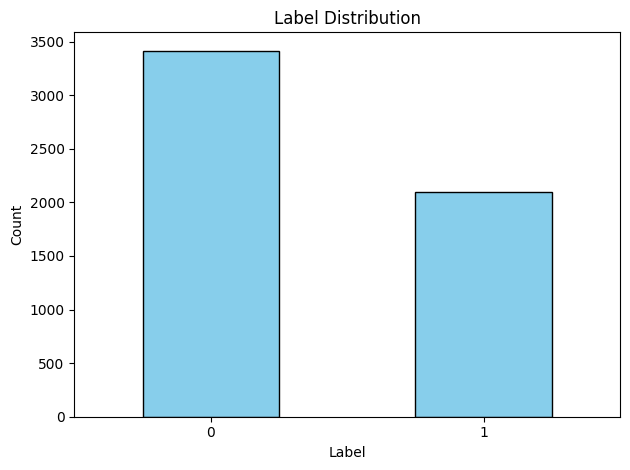

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Count the number of instances per label
label_counts = df['label'].value_counts()
print("Label Counts:\n", label_counts)

# 2. Show the percentage distribution of labels
label_percentages = df['label'].value_counts(normalize=True) * 100
print("\nLabel Percentages:\n", label_percentages.round(2))

# 3. Optional: Visualize the label distribution
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [8]:
def preprocess_text(text):
    text = str(text).lower()  
    text = text.lower()
    text = re.sub(r"@\w+", "", text) 
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"\d+", "", text) 
    text = re.sub(r"[^\u0B80-\u0BFFa-zA-Z\s]", "", text)  # Keep only Tamil & English words
    text = re.sub(r"\s+", " ", text).strip() 
    
    words = indic_tokenize.trivial_tokenize(text)  # Tokenize Tamil words
    words = [word for word in words if word not in tamil_stopwords]  # Remove Tamil stopwords
    
    return " ".join(words)  

df["clean_text"] = df["text"].apply(preprocess_text)
fdf["clean_text"] = fdf["text"].apply(preprocess_text)

print(df[["text", "clean_text"]].head())


                                                text  \
0  Indha ariya kandupidippin moolam neenga solla ...   
1        @vijayakumarp7959  unmai therincha nee pesu   
2  Inga erukka yella dev... boys  vadakkan vadakk...   
3  பீகாரி பிரசாந்த் கிஷோரிடம் கொடுத்த 350 கோடியை ...   
4       Mumbai Bangalore la 80% percentage outsiders   

                                          clean_text  
0  indha ariya kandupidippin moolam neenga solla ...  
1                           unmai therincha nee pesu  
2  inga erukka yella dev boys vadakkan vadakkan s...  
3  பீகாரி பிரசாந்த் கிஷோரிடம் கொடுத்த கோடியை எப்ப...  
4           mumbai bangalore la percentage outsiders  


In [9]:
print(fdf[["text", "clean_text"]].head())

                                                text  \
0  Humanity paatha intha slag countries prblm var...   
1               Avanga Holi kondada oruku poranga da   
2    Avangala avanga ooruke anupura vazhiya parunga.   
3  பைத்தியமாடா நீ.. நான் சோழிய வேளாளர். நான் என் ...   
4  Caste is there  parayan think to marry higheru...   

                                          clean_text  
0  humanity paatha intha slag countries prblm var...  
1               avanga holi kondada oruku poranga da  
2     avangala avanga ooruke anupura vazhiya parunga  
3  பைத்தியமாடா நீ நான் சோழிய வேளாளர் நான் என் அப்...  
4  caste is there parayan think to marry higherup...  


In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=7000)  # Use unigrams and bigrams
X_train = vectorizer.fit_transform(df["clean_text"]) 
y_train  = df["label"] 


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [11]:
svm_model = SVC(kernel="linear", probability=True)  
svm_model.fit(X_train, y_train)


SVC(kernel='linear', probability=True)

In [15]:
from sklearn.metrics import classification_report

# 1. Preprocess the test-with-labels dataset
tdf["clean_text"] = tdf["text"].apply(preprocess_text)

# 2. Vectorize the cleaned text
X_test = vectorizer.transform(tdf["clean_text"])
y_test = tdf["label"]

# 3. Generate predictions using the trained SVM model
y_pred = svm_model.predict(X_test)

# 4. Print the classification report
report = classification_report(y_test, y_pred, target_names=["Non-Hate", "Hate"])
print(report)

              precision    recall  f1-score   support

    Non-Hate       0.74      0.86      0.80       970
        Hate       0.71      0.52      0.60       606

    accuracy                           0.73      1576
   macro avg       0.73      0.69      0.70      1576
weighted avg       0.73      0.73      0.72      1576



In [16]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)


LogisticRegression()

In [17]:
y_pred = logreg_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=["Non-Hate", "Hate"])
print(report)

              precision    recall  f1-score   support

    Non-Hate       0.71      0.91      0.80       970
        Hate       0.74      0.39      0.51       606

    accuracy                           0.71      1576
   macro avg       0.72      0.65      0.65      1576
weighted avg       0.72      0.71      0.69      1576



In [18]:
ensemble_model = VotingClassifier(estimators=[
    ("svm", svm_model),
    ("logreg", logreg_model)
], voting="soft")

ensemble_model.fit(X_train, y_train)


VotingClassifier(estimators=[('svm', SVC(kernel='linear', probability=True)),
                             ('logreg', LogisticRegression())],
                 voting='soft')

In [19]:
y_pred = ensemble_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=["Non-Hate", "Hate"])
print(report)

              precision    recall  f1-score   support

    Non-Hate       0.73      0.88      0.80       970
        Hate       0.72      0.48      0.58       606

    accuracy                           0.73      1576
   macro avg       0.72      0.68      0.69      1576
weighted avg       0.73      0.73      0.71      1576



In [20]:
X_fdf = vectorizer.transform(fdf["clean_text"])

fdf_predictions = ensemble_model.predict(X_fdf)

fdf_result = fdf[["id"]].copy()  
fdf_result["predicted_label"] = fdf_predictions 


fdf_result.to_csv("fdf_predictions.csv", index=False, header=False)

